# Chapter 3. Unsupervised Learning methods.
# Part 2. Data Preprocessing: PCA, NMF, t-SNE

PCA - principal component analysis

NMF - (non-negative matrix factorization) feature extraction

t-SNE - (t-distributed stochastic neighbor embedding) visualization with scatter plots

## - PCA

PCA principle is about dataset rotation so samples wouldn't correlate

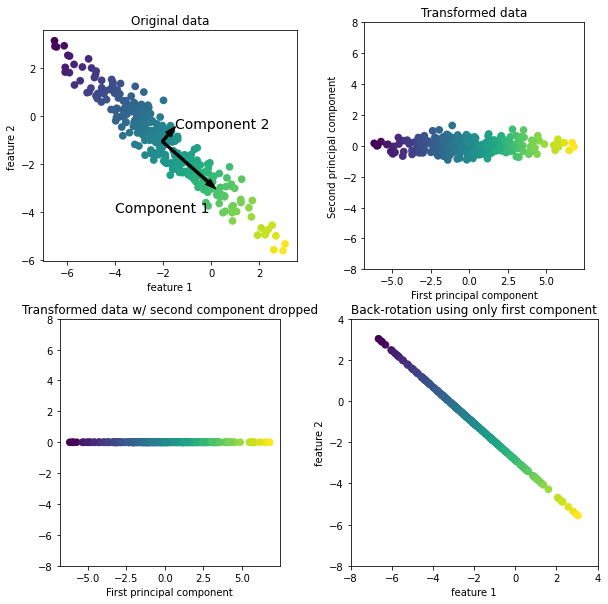

In [2]:
import mglearn
mglearn.plots.plot_pca_illustration()

^ Component is an axis that includes the most of information in dataset (axis of highest data dispersion) picked up iteratively

## PCA for data visualiztion

To get better clue of dataset without PCA it's useful to look at class comparison by a feature:

Text(0, 0.5, 'frequency')

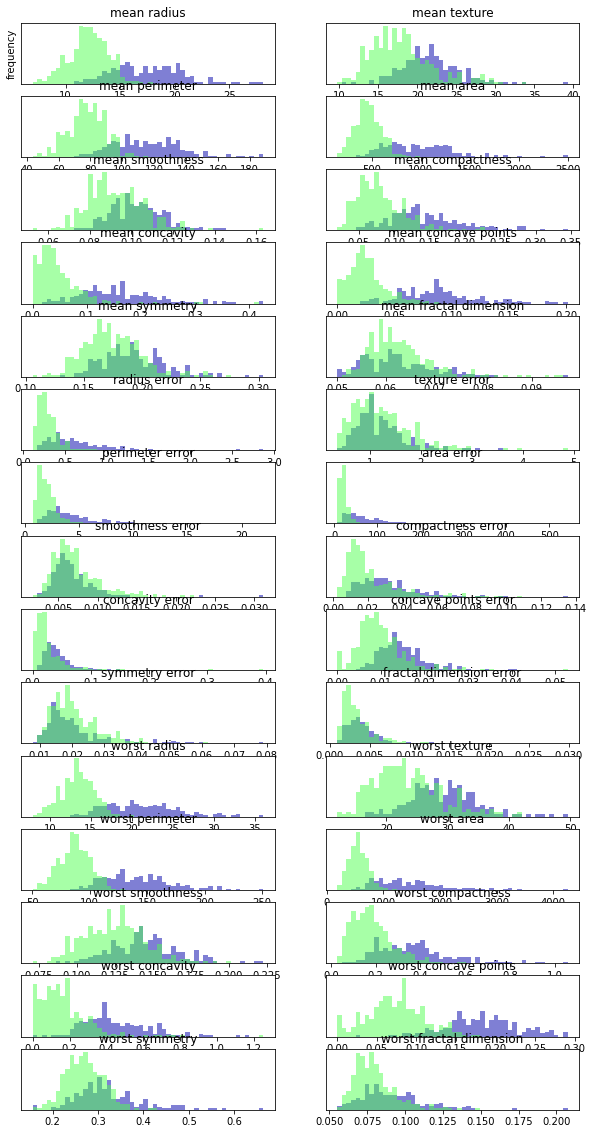

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15,2, figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=0.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel('feature value')
ax[0].set_ylabel('frequency')

^ 'worst cancave points' is pretty useful and 'smoothness error' is not. But this diagram doesn't account for the dependensies between features.

To get better clue of dataset with feature dependensies and correlations it's useful to find principal components via PCA (to prescaled data):

Source dataset shape: (569, 30)
New dataset shape: (569, 2)


Text(0, 0.5, 'Second principal component')

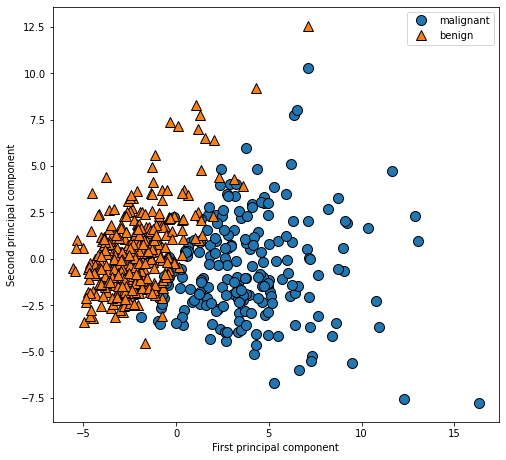

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#-----prescaling data and PCA implementation
#--initialization, building and applying scaler
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

#--initialization, building and applying PCA.
#dimensionality reduction is made by giving an argument to...
#...a PCA object as a count of needed components
pca = PCA(n_components=2)
#'.fit' finds principal components
pca.fit(X_scaled)
#'.transform' rotates and moves data
X_pca = pca.transform(X_scaled)

#--datasets comparison
print('Source dataset shape: {}'.format(str(X_scaled.shape)))
print('New dataset shape: {}'.format(str(X_pca.shape)))

#-----visualizing PCA dataset
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

Principal components are stored in 'components_' and columns are the source features:

Principal components data shape: (2, 30)
Principal components:
 [[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Principal components')

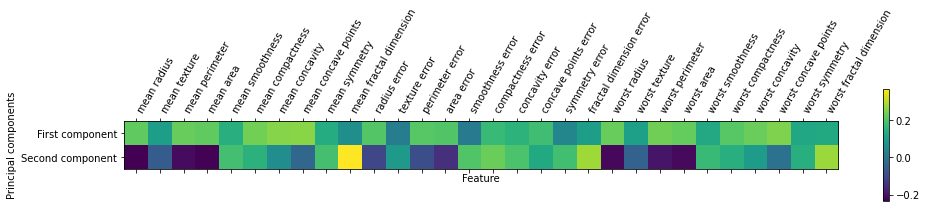

In [5]:
print('Principal components data shape: {}'.format(pca.components_.shape))
print('Principal components:\n {}'.format(pca.components_))

#PCA components visualization via heatmap
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

^ color intensivity tells about correlation strength between all the rest features for component

## PCA for feature extraction (eigenfaces)

Applying PCA to image dataset made of pixels generates a new feature space instead of the original space of every pixel as a feature itself.

New generated feature space could be more well interpreted, more inforamtive and more compact. Components as a features are not pixels anymore but images that represent some characteristics of train samples. The less the count of components, the less is model accuracy to reconstruct image.

#### Dataset loading and preparing:

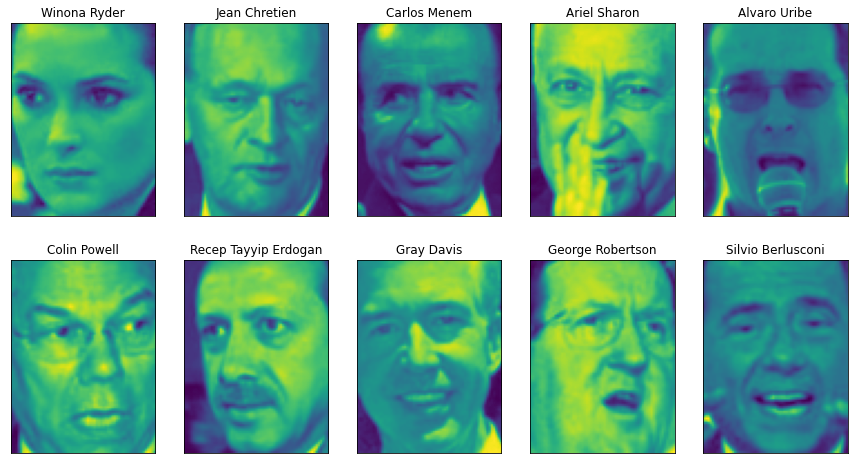

In [6]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

^ Gain data is asymmetrical (some of people got overwhelming count of images). So dataset need to be fixed by taking only 50 images as maximum for a person.

Making dataset symmetrical:

In [8]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

<ipython-input-8-b940f3f86508>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(people.target.shape, dtype=np.bool)


Changing diapason of brightness from 0 t0 255 to 0 to 1:

In [10]:
X_people = X_people / 255

#### PCA implementation and applying:

In [13]:
from sklearn.model_selection import train_test_split

#-----dataset loading and splitting
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

#-----pca initialization and building
#'whiten' is a param to scale generated components...
#...as like as StandardScaler do.
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Original dataset: {}'.format(X_train.shape))
print('PCA dataset: {}'.format(X_train_pca.shape))

Original dataset: (1547, 5655)
PCA dataset: (1547, 100)


Applying original dataset and PCA dataset to compare results:

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
knn2 = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca, y_train)

print('Original dataset accuracy: {}'.format(knn1.score(X_test, y_test)))
print('PCA dataset accuracy: {}'.format(knn2.score(X_test_pca, y_test)))

Original dataset accuracy: 0.23449612403100775
PCA dataset accuracy: 0.3062015503875969


^ Accuracy with PCA dataset increased

#### Components render (first of them):

Shape of pca.components_: (100, 5655)


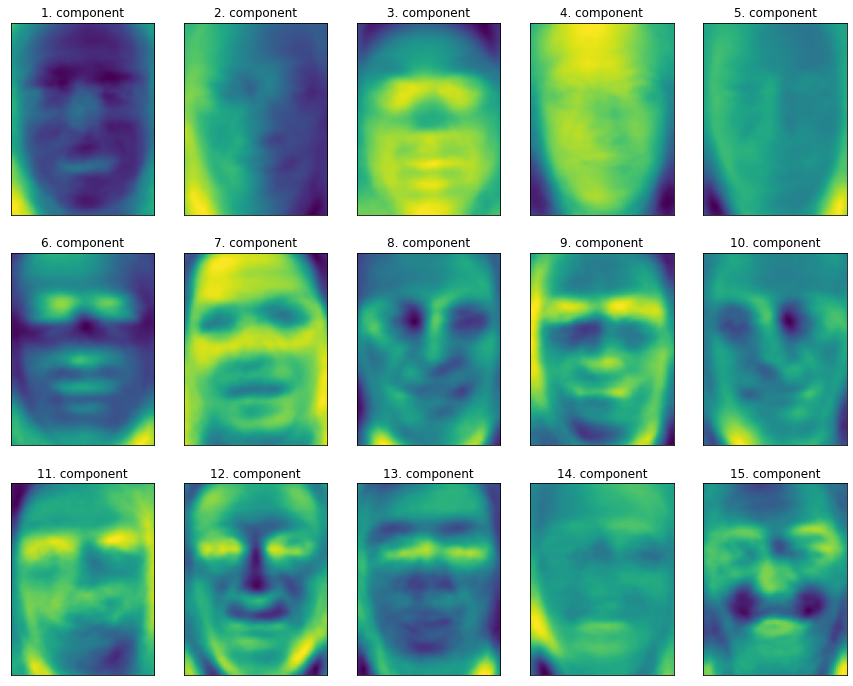

In [17]:
print('Shape of pca.components_: {}'.format(pca.components_.shape))
fix, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('{}. component'.format((i+1)))